In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scienceplots
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import StateSpace, lsim
from torch import nn
import torch
import torchvision
plt.rcParams.update({
    "text.usetex": True,
    })



## Best Hyperparameters so far:

#### hidden_layers = 2 
#### hidden_dim = 8
#### lr = 0.01
#### numbers_systems = 8
#### epochs = 800
#### batch_size = 16

In [26]:
def runSimulation(k,batchsize):
    # parameters
    m = 0.1  # mass of the pendulum
    k_spring = 5  # spring constant
    b = 1.2  # damping coefficient
    f = 1.1  # air friction
    g = 9.81  # acceleration due to gravity
    r0 = 1  # natural length of the spring

    BatchListeX = []
    BatchListeY = []

    # system of differential equations
    def system(y, t):
        x1, x2, x3, x4 = y
        dx1 = x2
        dx2 = (m*g*np.cos(x3) - k_spring*(x1 - r0) - b*x2 + m*x1*x4**2) / m
        dx3 = x4
        dx4 = (-2*x2*x4 - g*np.sin(x3) - x3*((m*g*np.cos(x3) - k_spring*(x1 - r0) - b*x2 + m*x1*x4**2) / m) - f*x4) / (x1)
        #dx4 = (-2*x2*x4 - g*np.sin(x3)) / (x1)
        return [dx1, dx2, dx3, dx4]

    number_states = 4
    number_samples = 10000
    n = number_samples-k
    X = np.zeros((n,batchsize,number_states))
    Y = np.zeros((n,batchsize,number_states))

    for i in range(batchsize):
        # initial conditions
        x1_0 = r0 + np.random.rand()*2  # the pendulum starts at the natural length of the spring
        x2_0 = np.random.rand()*2  # the pendulum starts at rest
        x3_0 = np.random.rand()/2  # the pendulum is slightly displaced from the vertical position
        x4_0 = np.random.rand()*2  # the pendulum starts at rest

        # time points
        t = np.linspace(0, 10, number_samples)

        # solve ODE
        y = odeint(system, [x1_0, x2_0, x3_0, x4_0], t)

        new_x = y[:-k]
        new_y = y[k:]
        X[:,i,:] = new_x
        Y[:,i,:] = new_y

        
    input_tensor = torch.from_numpy(X).float()
    target_tensor = torch.from_numpy(Y).float()


    return input_tensor, target_tensor, t


In [27]:
def plot4State(t,y):
    # plot results
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.plot(t, y[:, 0])
    plt.title('Radius over time')
    plt.subplot(222)
    plt.plot(t, y[:, 1])
    plt.title('Change of radius over time')
    plt.subplot(223)
    plt.plot(t, y[:, 2])
    plt.title('Angle over time')
    plt.subplot(224)
    plt.plot(t, y[:, 3])
    plt.title('Angular velocity over time')
    plt.tight_layout()
    plt.show()

In [28]:
m = nn.LogSigmoid()


In [89]:
# neural network

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps"
device = torch.device(device)


class CustomRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Parameters for the RNN cell
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        combined = self.Wxh(x) + self.Whh(h)
        activation = nn.LeakyReLU()
        return activation(combined)


class MultiLayerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, batch_size):
        super(MultiLayerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        # Define a list of custom RNN cells
        self.rnn_cells = nn.ModuleList([CustomRNNCell(input_size if i == 0 else hidden_size, hidden_size)
                                        for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #batch_size = x.size(0) #alt, war falsch, wieso auch immer, hat den fehler verursacht mit den hohen dimensionalitaeten
        batch_size = self.batch_size
        #print(f'batch size = {batch_size}')    #zum debuggen benutzt

        # Initialize hidden state with zeros for each layer
        hidden_states = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]
    
        # Forward through multiple RNN layers
        for layer_idx in range(self.num_layers):
            # Get the current RNN cell
            rnn_cell = self.rnn_cells[layer_idx]

            # Forward through the RNN cell
            hidden_states[layer_idx] = rnn_cell(x if layer_idx == 0 else hidden_states[layer_idx - 1],
                                                hidden_states[layer_idx])

        # Take the output from the last layer
        out = self.fc(hidden_states[-1])
        return out


In [80]:
# initialize the neural network and set hyperparams
number_states = 4
k = 1  # number of timesteps we look back 

input_dim = number_states * k
output_dim = number_states
hidden_dim = 8
num_layers = 2

model = MultiLayerRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
criterion = nn.MSELoss()

In [81]:
input_tensor, target_tensor, t = runSimulation(1,128)
print(f'input_tensor has shape: {input_tensor.shape}')
print(f'target_tensor has shape: {target_tensor.shape}')

input_tensor has shape: torch.Size([9999, 128, 4])
target_tensor has shape: torch.Size([9999, 128, 4])


In [82]:
## initiate training phase
number_systems = 5
for i in range(number_systems):
    input_tensor, target_tensor, t = runSimulation(1,16)

    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)

    num_epochs = 800
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_tensor)
        loss = criterion(outputs, target_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'R.{i+1} - - - Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


R.1 - - - Epoch [100/800], Loss: 0.03274557366967201
R.1 - - - Epoch [200/800], Loss: 0.0038073419127613306
R.1 - - - Epoch [300/800], Loss: 0.0016547878040000796
R.1 - - - Epoch [400/800], Loss: 0.0011057601077482104
R.1 - - - Epoch [500/800], Loss: 0.0008493650238960981
R.1 - - - Epoch [600/800], Loss: 0.0006053149700164795
R.1 - - - Epoch [700/800], Loss: 0.00023973330098669976
R.1 - - - Epoch [800/800], Loss: 0.0003244747349526733
R.2 - - - Epoch [100/800], Loss: 5.543006773223169e-05
R.2 - - - Epoch [200/800], Loss: 0.00010772270616143942
R.2 - - - Epoch [300/800], Loss: 1.7569043848197907e-05
R.2 - - - Epoch [400/800], Loss: 1.284801237488864e-05
R.2 - - - Epoch [500/800], Loss: 1.5971061657182872e-05
R.2 - - - Epoch [600/800], Loss: 0.0001354123087367043
R.2 - - - Epoch [700/800], Loss: 1.2931892342749052e-05
R.2 - - - Epoch [800/800], Loss: 0.00012211341527290642
R.3 - - - Epoch [100/800], Loss: 1.94536114577204e-05
R.3 - - - Epoch [200/800], Loss: 1.1274531971139368e-05
R.3 - 

In [86]:
### evaluate the model on test set

model.eval()

input_tensor_test, target_tensor_test, t = runSimulation(1,1)
input_tensor_test = input_tensor_test.to(device)
target_tensor_test = target_tensor_test.to(device)

# Get predictions from the model
with torch.no_grad():
    predicted_output = model(input_tensor_test)

# Convert predicted_output tensor to numpy array
predicted_output_np = predicted_output.cpu().numpy()
actual_target_np = target_tensor_test.cpu().numpy()

In [87]:
predicted_output_np.shape
actual_target_np.shape

(9999, 1, 4)

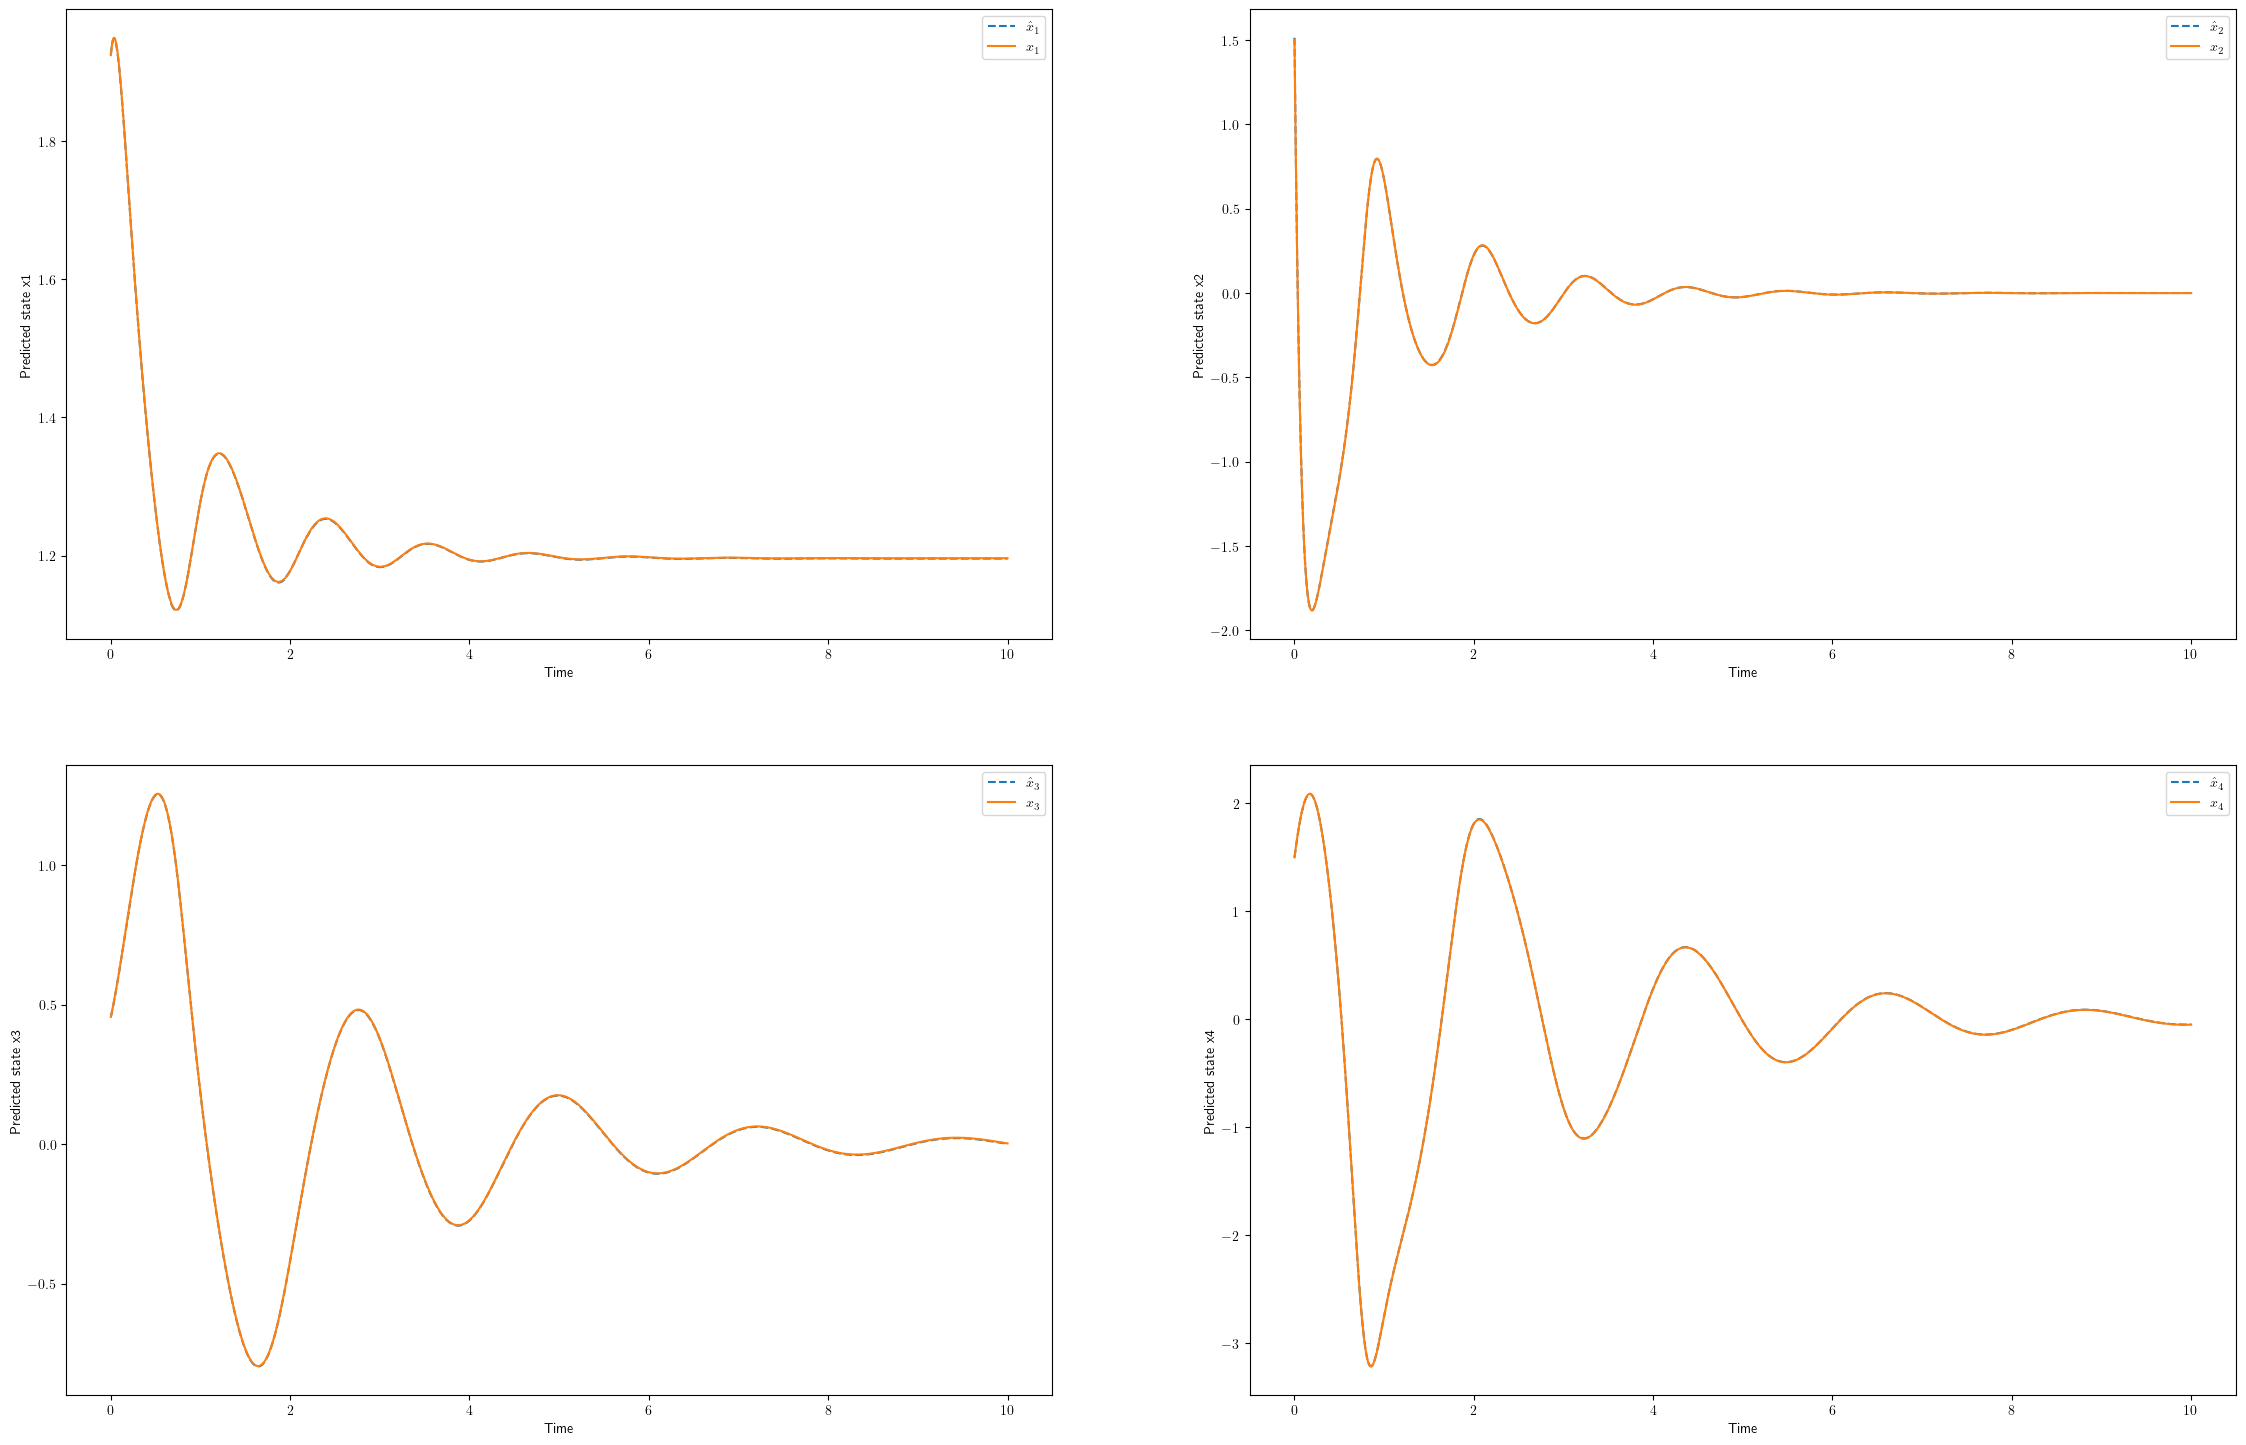

In [88]:
plt.figure(figsize=(28, 18))
k=1
plt.subplot(2,2,1)
plt.plot(t[k:],predicted_output_np[:,0,0], label=r'$\hat{x}_1$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,0],label=r"$x_1$")
plt.xlabel('Time')
plt.ylabel('Predicted state x1')
plt.legend()

plt.subplot(2,2,2)
plt.plot(t[k:],predicted_output_np[:,0,1], label=r'$\hat{x}_2$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,1],label=r"$x_2$")
plt.xlabel('Time')
plt.ylabel('Predicted state x2')
plt.legend()

plt.subplot(2,2,3)
plt.plot(t[k:],predicted_output_np[:,0,2], label=r'$\hat{x}_3$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,2],label=r"$x_3$")
plt.xlabel('Time')
plt.ylabel('Predicted state x3')
plt.legend()  

plt.subplot(2,2,4)
plt.plot(t[k:],predicted_output_np[:,0,3], label=r'$\hat{x}_4$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,3],label=r"$x_4$")
plt.xlabel('Time')
plt.ylabel('Predicted state x4')
plt.legend()

plt.show()

TypeError: plot4State() missing 1 required positional argument: 'y'

In [93]:
# run test on different hyperparams
# dic that saves loss for different hyperparams

loss_dict = {}
counter = 0
hidden_dim_list = [2,4,6]
num_layers_list = [1,2,3]
lr_list = [0.01,0.001,0.1]
num_epochs_list = [500]
num_systems_list = [5]
batch_size_list = [8,16]

amount_hyperparams = len(hidden_dim_list)*len(num_layers_list)*len(lr_list)*len(num_epochs_list)*len(num_systems_list)

# different hyperparams [hidden_dim, num_layers, lr, num_epochs, num_systems]
for hidden_dim in hidden_dim_list:
    for num_layers in num_layers_list:
        for lr in lr_list:
            for num_epochs in num_epochs_list:
                for num_systems in num_systems_list:
                    for batch_size in batch_size_list:

                        model = MultiLayerRNN(input_dim, hidden_dim, output_dim, num_layers, batch_size).to(device)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                        criterion = nn.MSELoss()
                        
                        #counter for which round we are in 
                        counter +=1
                        #### run training phase
                        for i in range(number_systems):
                            input_tensor, target_tensor, t = runSimulation(1,batch_size)

                            input_tensor = input_tensor.to(device)
                            target_tensor = target_tensor.to(device)

                            for epoch in range(num_epochs):
                                optimizer.zero_grad()

                                # Forward pass
                                outputs = model(input_tensor)
                                loss = criterion(outputs, target_tensor)

                                # Backward pass and optimization
                                loss.backward()
                                optimizer.step()

                                if (epoch + 1) % (num_epochs/5) == 0:
                                    print(f'Round {i+1}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}    ROUND {counter}/{amount_hyperparams}')

                        ### run test phase:
                        avg_loss = 0
                        num_test_iterations = 100
                        for i in range(num_test_iterations):
                            model.eval()

                            input_tensor_test, target_tensor_test, t = runSimulation(1,batch_size)
                            input_tensor_test = input_tensor_test.to(device)
                            target_tensor_test = target_tensor_test.to(device)

                            # Get predictions from the model
                            with torch.no_grad():
                                predicted_output = model(input_tensor_test)
                            loss = criterion(predicted_output, target_tensor_test)
                            avg_loss += loss.item()
                            
                        loss_dict[(hidden_dim, num_layers, lr, num_epochs, num_systems, batch_size)] = avg_loss/num_test_iterations

                                            

Round 1, Epoch [100/500], Loss: 0.05725318565964699    ROUND 1/27
Round 1, Epoch [200/500], Loss: 0.040781665593385696    ROUND 1/27
Round 1, Epoch [300/500], Loss: 0.032602835446596146    ROUND 1/27
Round 1, Epoch [400/500], Loss: 0.028893698006868362    ROUND 1/27
Round 1, Epoch [500/500], Loss: 0.026995046064257622    ROUND 1/27
Round 2, Epoch [100/500], Loss: 0.038723818957805634    ROUND 1/27
Round 2, Epoch [200/500], Loss: 0.03574255108833313    ROUND 1/27
Round 2, Epoch [300/500], Loss: 0.03348904848098755    ROUND 1/27
Round 2, Epoch [400/500], Loss: 0.031501028686761856    ROUND 1/27
Round 2, Epoch [500/500], Loss: 0.029635107144713402    ROUND 1/27
Round 3, Epoch [100/500], Loss: 0.034745264798402786    ROUND 1/27
Round 3, Epoch [200/500], Loss: 0.030688567087054253    ROUND 1/27
Round 3, Epoch [300/500], Loss: 0.027060121297836304    ROUND 1/27
Round 3, Epoch [400/500], Loss: 0.02438262104988098    ROUND 1/27
Round 3, Epoch [500/500], Loss: 0.02240080200135708    ROUND 1/27


In [94]:
loss_dict

{(2, 1, 0.01, 500, 5, 8): 0.015930449212901293,
 (2, 1, 0.01, 500, 5, 16): 0.015404886100441217,
 (2, 1, 0.001, 500, 5, 8): 0.030472841607406737,
 (2, 1, 0.001, 500, 5, 16): 0.015973503049463034,
 (2, 1, 0.1, 500, 5, 8): 0.016507566999644042,
 (2, 1, 0.1, 500, 5, 16): 0.09354368353262543,
 (2, 2, 0.01, 500, 5, 8): 0.015724916090257467,
 (2, 2, 0.01, 500, 5, 16): 0.015763824302703143,
 (2, 2, 0.001, 500, 5, 8): 0.02262514762580395,
 (2, 2, 0.001, 500, 5, 16): 0.017422198513522745,
 (2, 2, 0.1, 500, 5, 8): 0.01677796964533627,
 (2, 2, 0.1, 500, 5, 16): 0.015446364944800735,
 (2, 3, 0.01, 500, 5, 8): 0.016587020815350115,
 (2, 3, 0.01, 500, 5, 16): 0.015235641030594707,
 (2, 3, 0.001, 500, 5, 8): 0.023872056631371378,
 (2, 3, 0.001, 500, 5, 16): 0.02816219484433532,
 (2, 3, 0.1, 500, 5, 8): 0.015713317790068685,
 (2, 3, 0.1, 500, 5, 16): 0.06279874462634324,
 (4, 1, 0.01, 500, 5, 8): 5.313814101100434e-05,
 (4, 1, 0.01, 500, 5, 16): 1.441373560737702e-06,
 (4, 1, 0.001, 500, 5, 8): 0.0024

In [95]:
min_value = min(loss_dict.values())  # Get the minimum value
keys_with_min_value = [key for key, value in loss_dict.items() if value == min_value]  # Get keys with the minimum value

print(f"Lowest value: {min_value} with hyperparams: \nhidden_dim = {keys_with_min_value[0][1]}, \nhidden_layers = {keys_with_min_value[0][1]}, \nlr = {keys_with_min_value[0][2]}, \nepochs = {keys_with_min_value[0][3]}, \nnum_systems = {keys_with_min_value[0][4]}, \nbatch_size = {keys_with_min_value[0][5]}")

Lowest value: 1.441373560737702e-06 with hyperparams: 
hidden_dim = 1, 
hidden_layers = 1, 
lr = 0.01, 
epochs = 500, 
num_systems = 5, 
batch_size = 16


In [96]:
keys_with_min_value[0][2]

0.01

2.5 min for 32 iterations
with epoch 100, 200
num list, 5,10

32*300*15

In [ ]:
32*300*15

In [ ]:
l  = []
for i in range(16):
    l.append(np.random.rand(100,4))

l

In [ ]:
a = np.stack(l,axis=1)
a

In [ ]:
a.shape